# Feature selection

In [11]:
from src.data_management import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### Loading data
Data is stored in 4 csv files located in the `data` folder. The files are:
- `caracteristiques-2022.csv` : contains the characteristics of the accidents
- `lieux-2022.csv` : contains the location of the accidents
- `usagers-2022.csv` : contains the users involved in the accidents
- `vehicules-2022.csv` : contains the vehicles involved in the accidents

In [12]:
caracteristiques = load_raw_data("data/caracteristiques-2022.csv")
lieux = load_raw_data("data/lieux-2022.csv")
usagers = load_raw_data("data/usagers-2022.csv")
vehicules = load_raw_data("data/vehicules-2022.csv")

### Merging the datasets
The goal being to predict the severity of an accident for a person, we want to keep 1 row per person. We will therefore merge the vehicles and the users datasets on 'id_vehicule' and then merge the resulting dataset with the characteristics dataset and the location dataset on 'Num_Acc'. 

In [13]:
joined_data = joined_data(caracteristiques, lieux, usagers, vehicules)

### Processing data
To prepare the data for the analysis, we replace the birth year 'an_nais' by the age of the user 'age' and we add a column 'secu' that contains the number of security equipments used by the user.

In [14]:
data = process_data(joined_data)

### Feature selection
We can now select the features that we want to use for the analysis. We will ignore the features that describe the location of the accident or its date and the IDs.

In [15]:
selected_features = [
    # 'Num_Acc', 
    # 'id_usager', 
    # 'id_vehicule', 
    # 'num_veh_x', 
    'place', 
    'catu', 
    'grav', 
	'sexe', 
    # 'trajet', 
    # 'secu1', 
    # 'secu2', 
    # 'secu3', 
    # 'locp', 
    # 'actp', 
    # 'etatp', 
    # 'num_veh_y', 
    'senc', 
    'catv', 
    # 'obs', 
    # 'obsm', 
    'obscar', 
    'choc', 
    'manv',
    'motor', 
    # 'occutc', 
    'catr', 
    # 'voie', 
    # 'v1', 
    # 'v2', 
    'circ', 
    # 'nbv', 
    'vosp',
    'prof', 
    # 'pr', 
    # 'pr1', 
    'plan', 
    # 'lartpc', 
    # 'larrout', 
    'surf', 
    'infra',
    'situ', 
    'vma', 
    # 'jour', 
    # 'mois', 
    # 'an', 
    # 'hrmn', 
    'lum', 
    # 'dep', 
    # 'com', 
    'agg',
    'int', 
    'atm', 
    'col', 
    # 'adr', 
    # 'lat', 
    # 'long', 
    'age', 
	'secu'
]

### Insights on the data

We can begin by plotting the availability of the data for each feature.

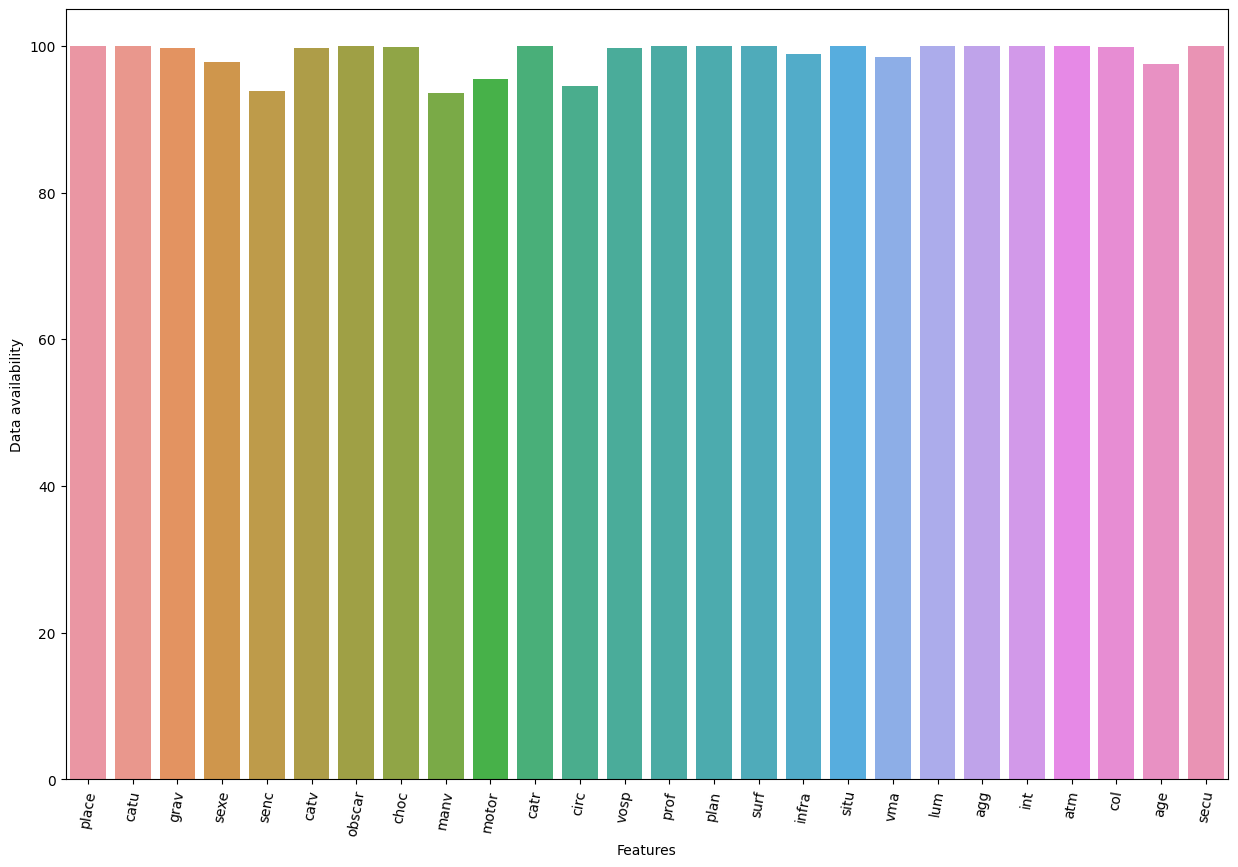

In [16]:
data_availability = [data_available(data, feature) for feature in selected_features]

plt.figure(figsize=(15, 10))
sns.barplot(x=selected_features, y=data_availability)
plt.xticks(rotation=80)
plt.xlabel("Features")
plt.ylabel("Data availability")
plt.show()


We can also plot the distribution of the features regarding the severity of the accident. It can help us to spot inconsistencies or high unbalances in the data.

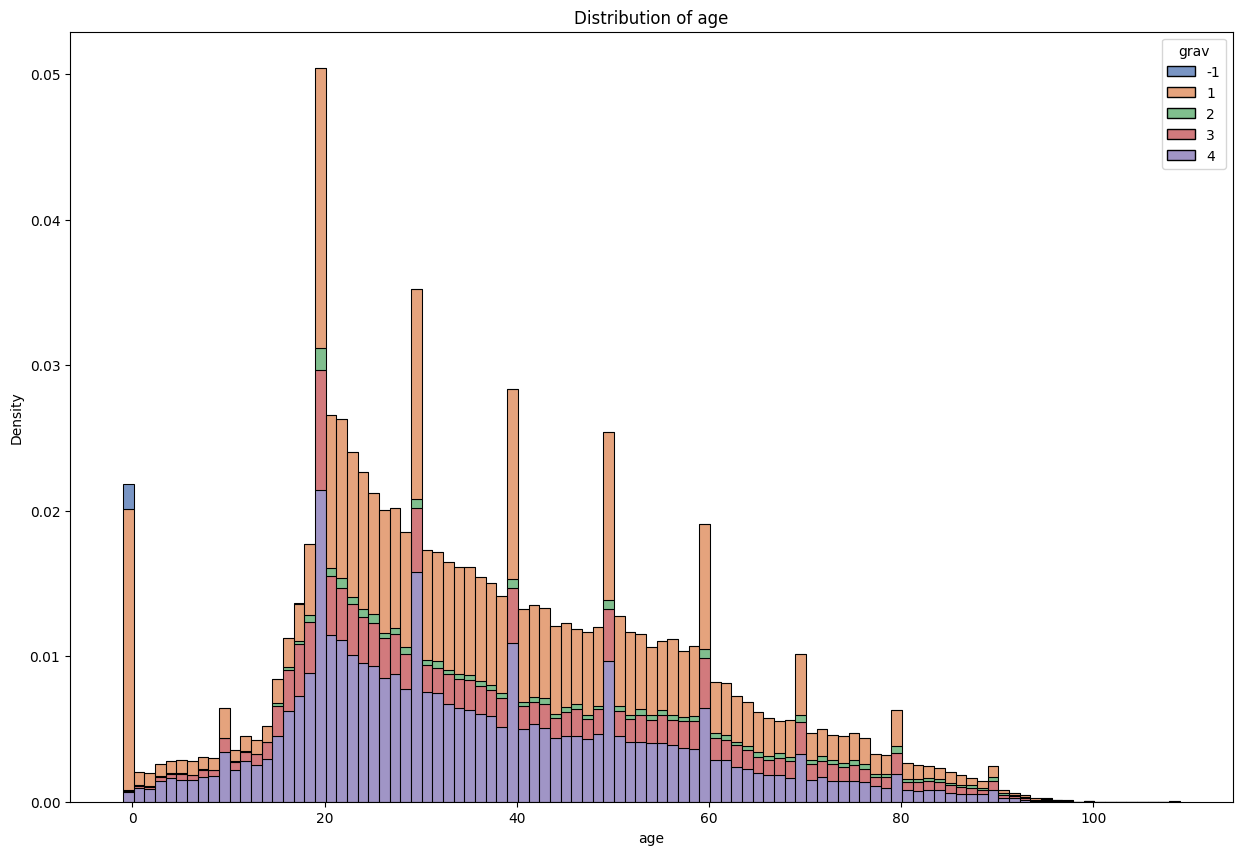

In [17]:
# nb_features = len(selected_features)
# nb_cols = 3
# nb_rows = nb_features//nb_cols + 1

# _, axes = plt.subplots(nb_rows, nb_cols, figsize=(40, 40))
# axes = axes.flatten()

# for i, feature in enumerate(selected_features):
#     sns.histplot(data=data, x=feature, ax=axes[i], hue="grav", stat="density")
#     axes[i].set_title(f"Distribution of {feature}")

# plt.show()

feature_to_plot = 'age'
plt.figure(figsize=(15, 10))
sns.histplot(data=data, x=feature_to_plot, hue="grav", stat="density", palette="deep", multiple='stack')
plt.title(f"Distribution of {feature_to_plot}")
plt.show()


It can also help to project the data in a lower dimension space to see if there are clusters or if the data is linearly separable.
If so, it would help us to choose the right model and identify the most important features.

(126662, 26)
(98644, 26)


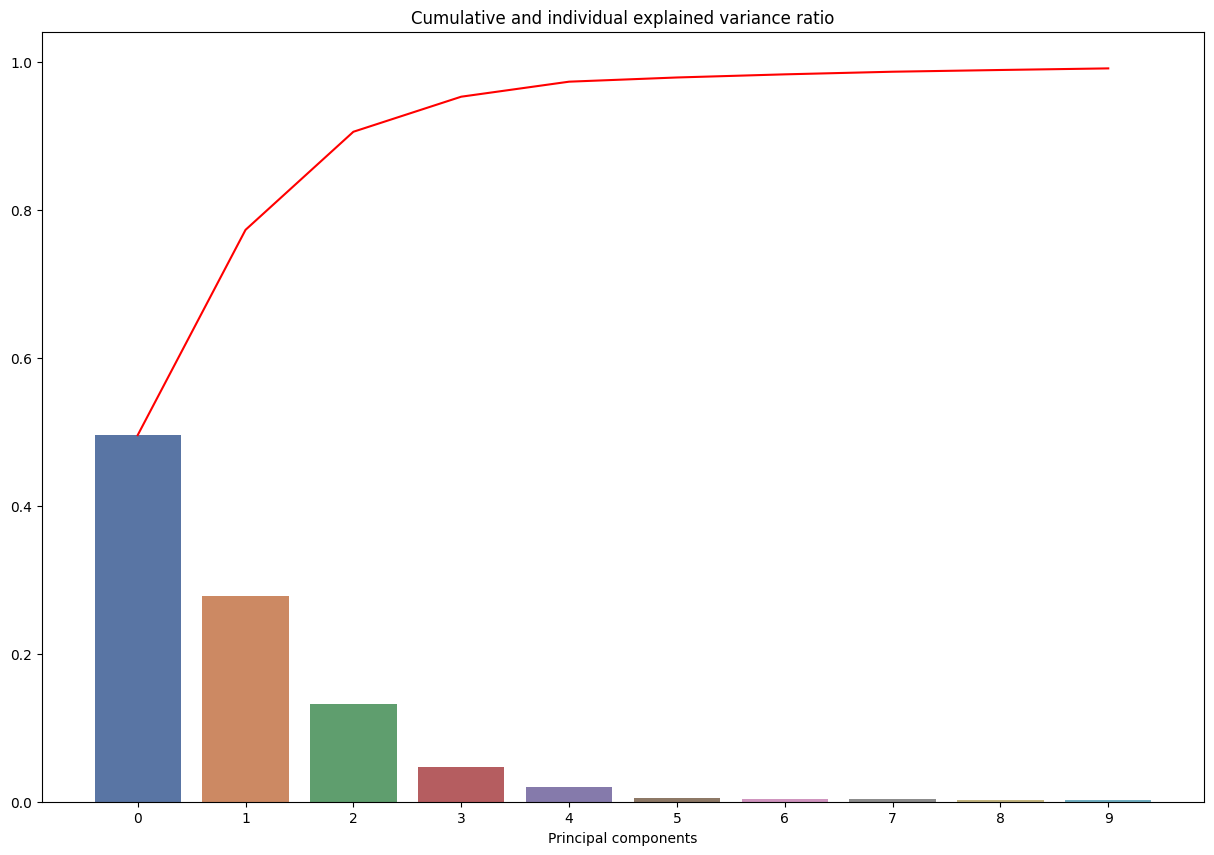

Silhouette score of the projected data regarding 'grav': -0.02148987506992636


In [18]:
Xy = select_features(data, selected_features)
print(Xy.shape)
Xy = remove_missing_values(Xy)
print(Xy.shape)
X = Xy.drop(columns=["grav"])
y = Xy["grav"]

# PCA
n_components = 10
pca = PCA(n_components=n_components)
X_PCA = pca.fit_transform(X)
var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(15, 10))
plt.title("Cumulative and individual explained variance ratio")
plt.xlabel("Principal components")
plt.xticks(range(1, n_components+1))
# Individual explained variance ratio
sns.barplot(x=list(range(n_components)), y=var_ratio, palette="deep")
# Cumulative explained variance ratio
# plt.plot(range(n_components), np.cumsum(var_ratio), c="orange")
sns.lineplot(x=range(n_components), y=np.cumsum(var_ratio), c="red")
plt.show()

# # Plot data
# plt.figure(figsize=(15, 10))
# sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], hue=y, palette="deep")
# plt.title("Data after PCA")
# plt.show()

# Silhouette score of the projected data regarding 'grav'
silhouette_avg = silhouette_score(X_PCA, y)
print(f"Silhouette score of the projected data regarding 'grav': {silhouette_avg}")

We see that the first 5 components of the PCA explain 99% of the variance of the data. We can therefore project the data in a 5D space.
It is now interesting to visualize which features are the most important in the projection.

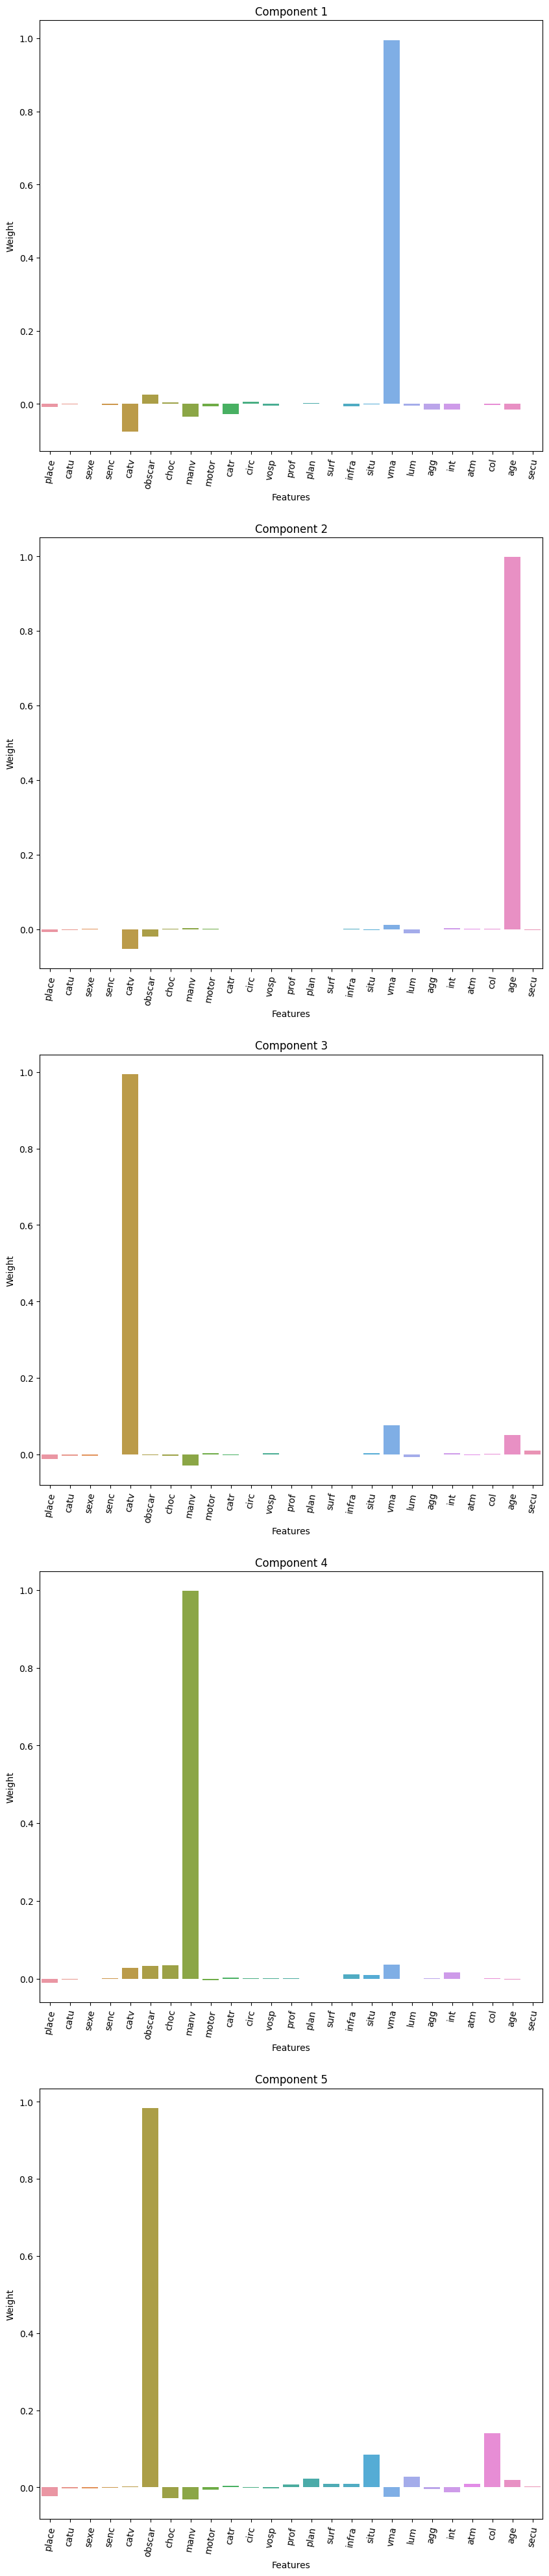

In [19]:
# Details on each component
n_components = 5
pca = PCA(n_components=n_components)
pca = pca.fit(X)

selected_features_without_grav = [feature for feature in selected_features if feature != "grav"]
components = [{selected_features_without_grav[i]: comp[i] for i in range(len(selected_features_without_grav))} for comp in pca.components_]

f, axes = plt.subplots(n_components, 1, figsize=(10, 50))
for i, comp in enumerate(components):
    sns.barplot(x=list(comp.keys()), y=list(comp.values()), ax=axes[i])
    axes[i].set_title(f"Component {i+1}")
    axes[i].set_xlabel("Features")
    axes[i].set_ylabel("Weight")
    axes[i].set_xticklabels(labels=list(comp.keys()), rotation=80)
plt.show()

We can plot the correlation matrixes of the original data and the projected data to see if the PCA managed to decrease the correlation between the features.

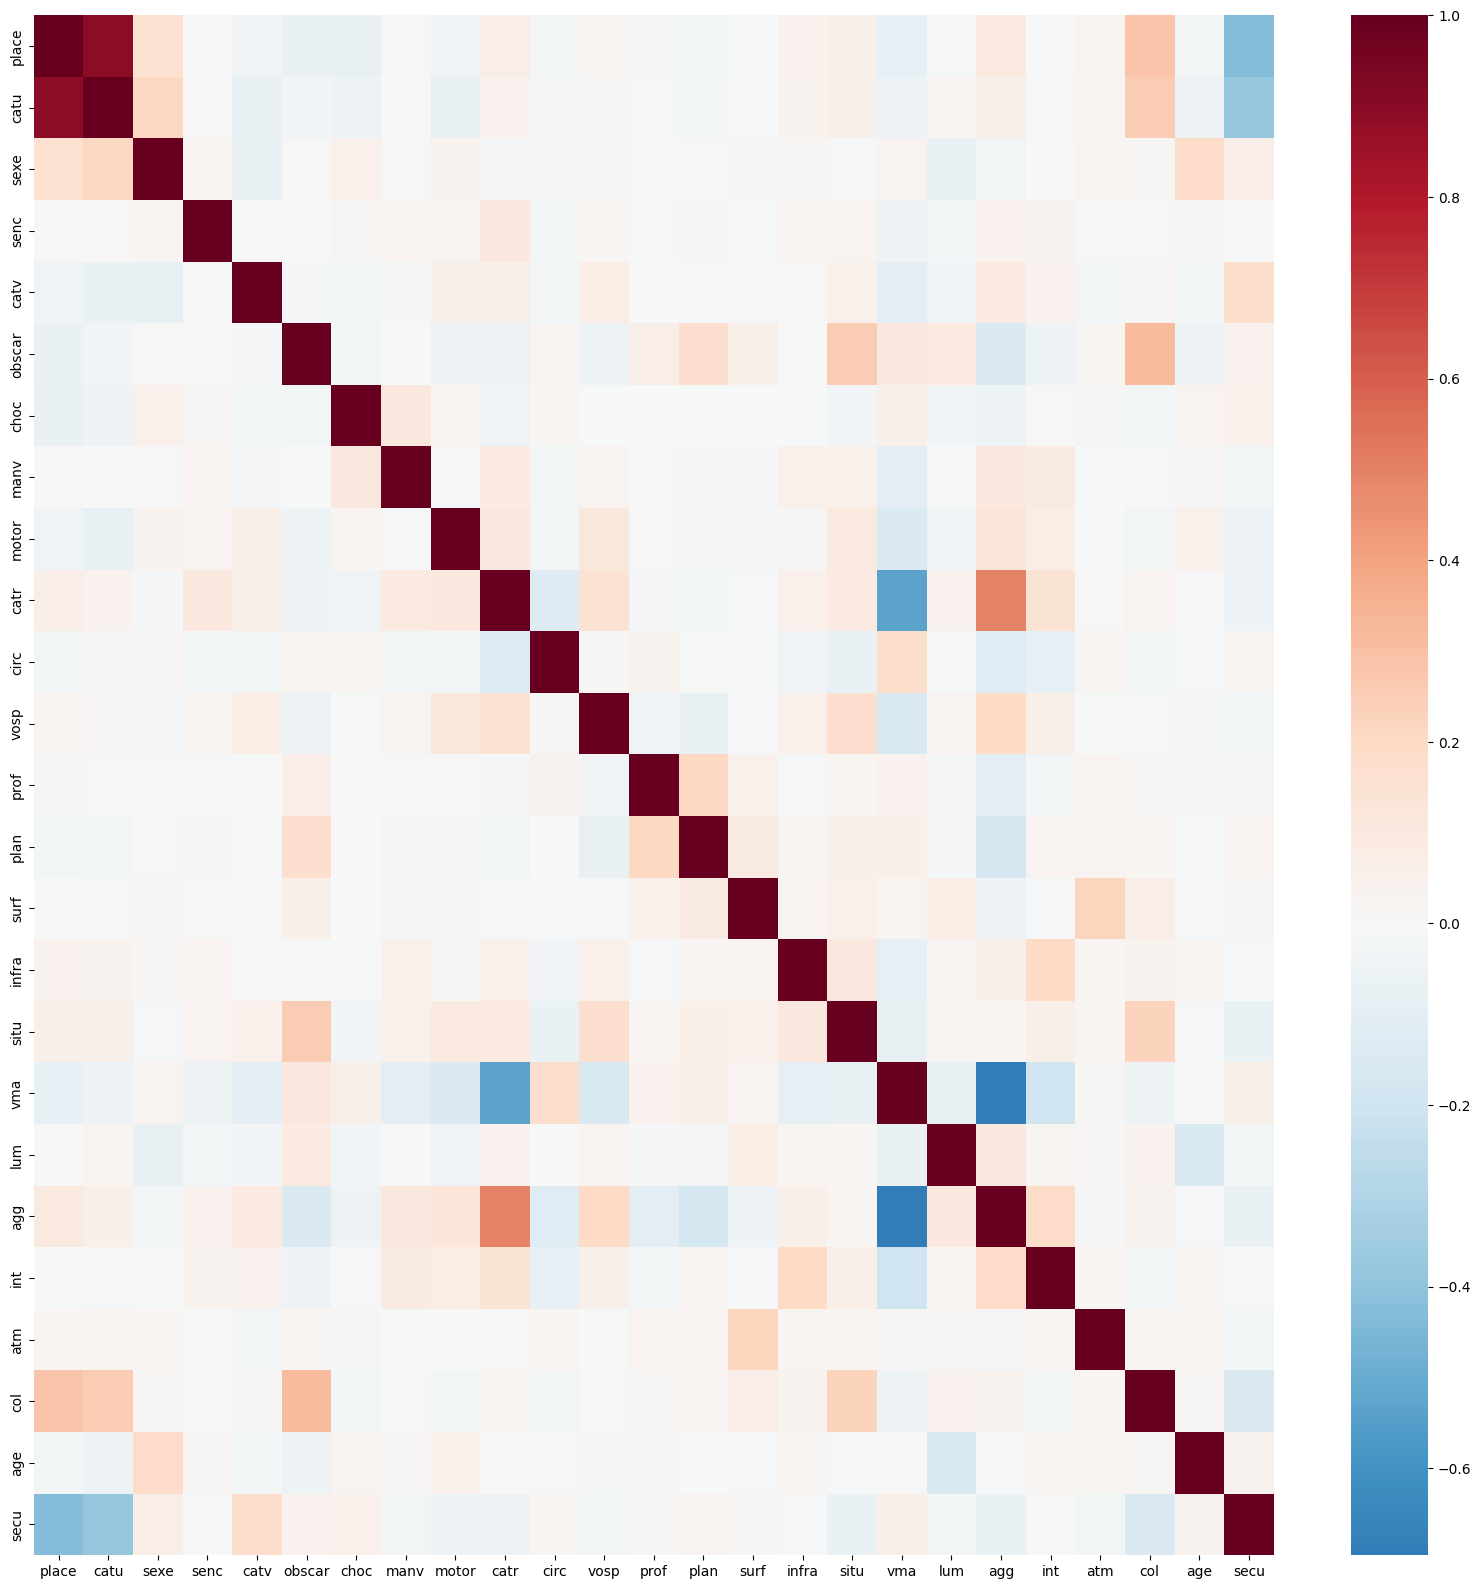

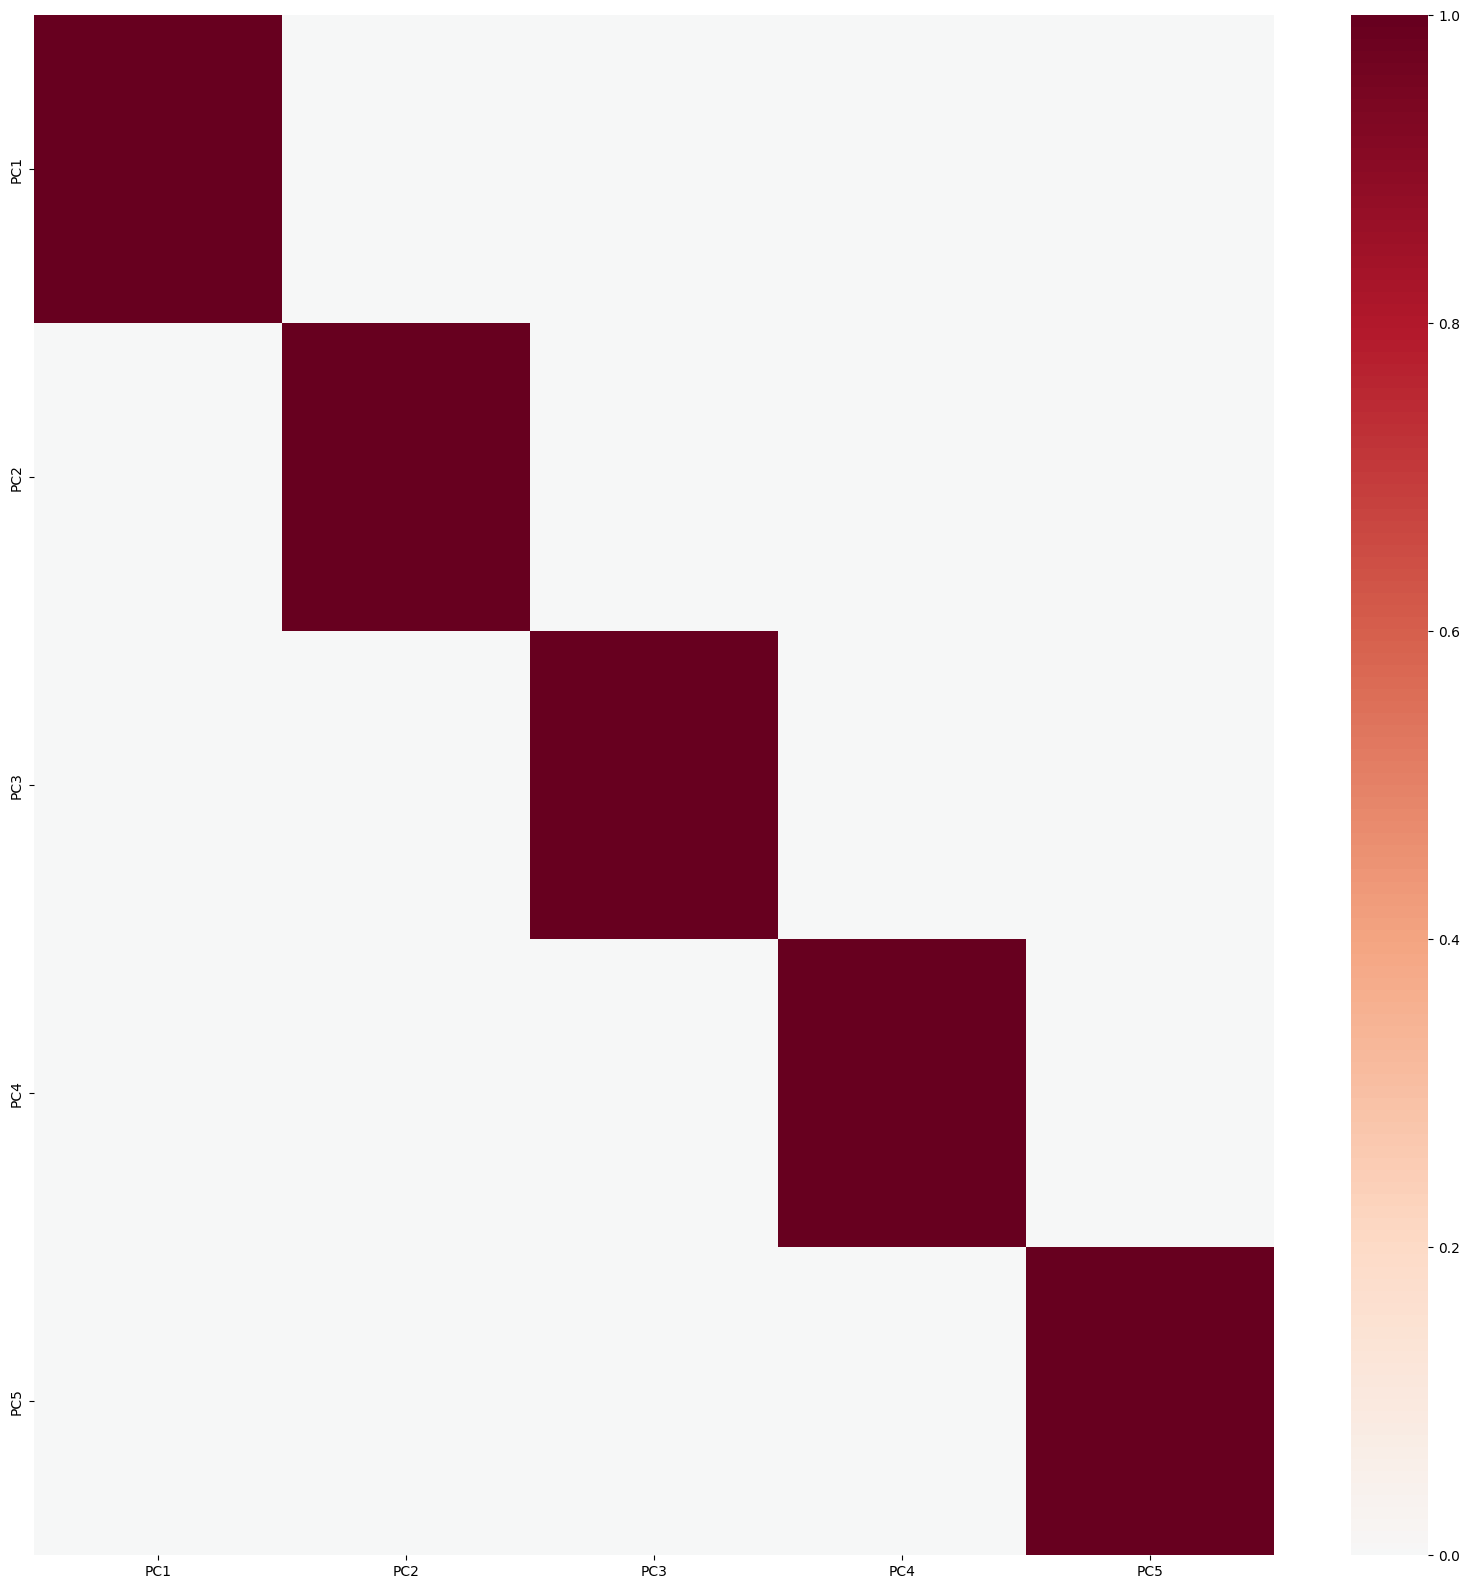

In [20]:
# Correlation matrix
# Without PCA
selected_data = data[selected_features_without_grav]
corr = selected_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, cmap='RdBu_r', center=0)
plt.show()

# With PCA
pca = PCA(n_components=5)
X_PCA = pca.fit_transform(X)
X_PCA = pd.DataFrame(X_PCA, columns=[f"PC{i+1}" for i in range(n_components)])
corr = X_PCA.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, cmap='RdBu_r', center=0)
plt.show()